In [13]:
import glob
import random
import math
import decimal
import re
import pandas as pd
import numpy as np
import itertools 

from sklearn import decomposition

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import BayesianGaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics


from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

import matplotlib.pyplot as plt
import seaborn as sns

set random seed

In [2]:
#random seed in jupyter notebooks have scope of cell only and it's not applicable for whole notebook
# so even after this we need to set random_state explicility
random.seed(11915043)

## P1 : IRIS – HIERARCHICAL FISHER

In [3]:
iris = pd.read_csv('DMG-2 Assignment Data Files/iris/iris.data', header=None, names =
                   ['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
iris.sample(5)

,sepal length,sepal width,petal length,petal width,class
48,5.3,3.7,1.5,0.2,Iris-setosa
67,5.8,2.7,4.1,1.0,Iris-versicolor
45,4.8,3.0,1.4,0.3,Iris-setosa
15,5.7,4.4,1.5,0.4,Iris-setosa
110,6.5,3.2,5.1,2.0,Iris-virginica


### Two classes in IRIS are more “similar” to each other. Find which ones using scatter plots. Lets say class 1 and class 2.

As seen in plots below 'Iris-versicolor' and 'Iris-virginica' are more similar to each other

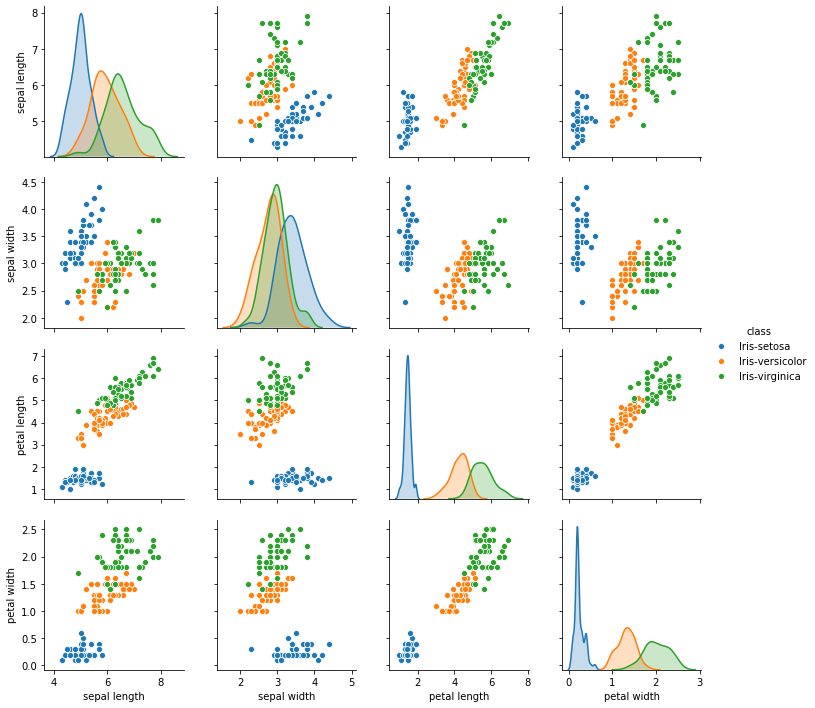

In [4]:
sns.pairplot(iris, hue = 'class')

### Lets create a “meta class” combining class 1 and class 2 (or whichever are the two most similar classes). Lets call it class 4.

In [5]:
iris['versi-virgi'] = np.where((iris['class'] == 'Iris-versicolor') | (iris['class'] == 'Iris-virginica'), 1, 0)
iris.sample(5)

,sepal length,sepal width,petal length,petal width,class,versi-virgi
69,5.6,2.5,3.9,1.1,Iris-versicolor,1
113,5.7,2.5,5.0,2.0,Iris-virginica,1
63,6.1,2.9,4.7,1.4,Iris-versicolor,1
106,4.9,2.5,4.5,1.7,Iris-virginica,1
104,6.5,3.0,5.8,2.2,Iris-virginica,1


In [6]:
train, test = train_test_split(iris, test_size=0.3, random_state=11915043)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


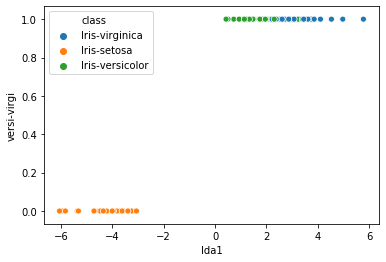

In [7]:
#Ref https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html

lda = LinearDiscriminantAnalysis()
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
target = 'versi-virgi'

lda1 = lda.fit(train[features], train[target])
lda1_dis = lda1.transform(train[features])
train['lda1'] = lda1_dis

ax = sns.scatterplot(x="lda1", y="versi-virgi", hue="class", data=train)


### Create the second Fisher projection by trying to discriminate class 1 from class 2 (the original two similar classes)

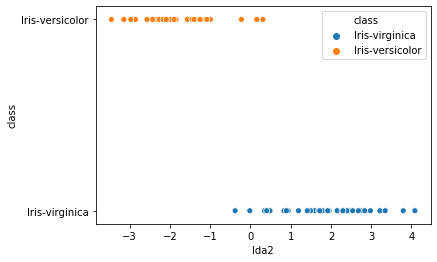

In [8]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
target = 'class'

train = train[(train['class'] == 'Iris-versicolor') | (train['class'] == 'Iris-virginica')]
lda = LinearDiscriminantAnalysis(n_components=1)
lda2 = lda.fit(train[features], train[target])
lda2_dis = lda2.transform(train[features])
train['lda2'] = lda2_dis

ax = sns.scatterplot(x="lda2", y="class", hue="class", data=train)

### Now project the entire data in these two projections and color code the class points.

In [9]:
test['lda1'] = lda1.transform(test[['sepal length', 'sepal width', 'petal length', 'petal width']])
test['lda2'] = lda2.transform(test[['sepal length', 'sepal width', 'petal length', 'petal width']])

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Comment on what you observed and did.

Plot how the original four features were classifying the data

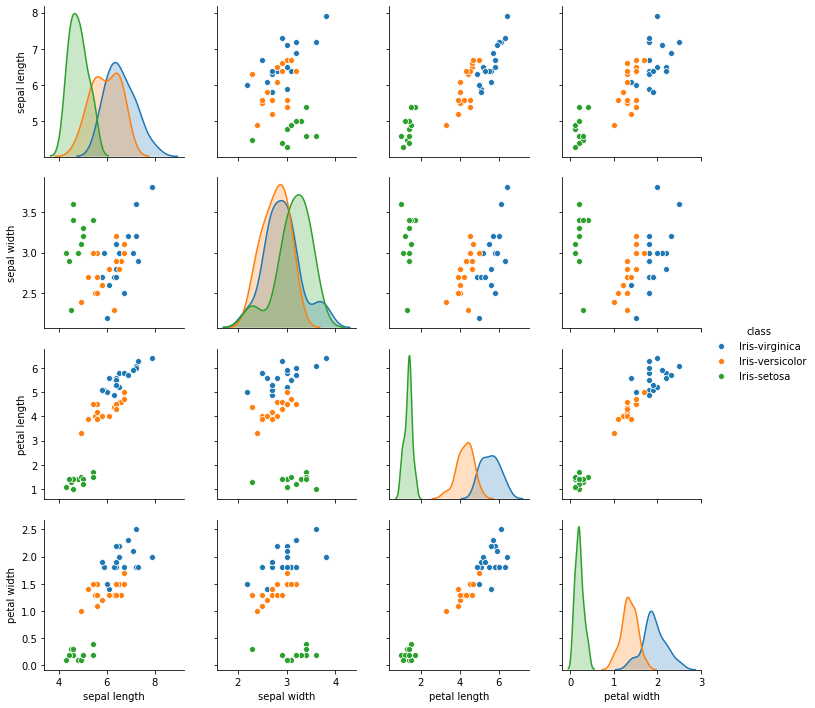

In [10]:
sns.pairplot(hue='class', data=test[['sepal length', 'sepal width', 'petal length', 'petal width', 'class']])

We can clearly see the difference between all three classes ie. setosa, versicolor and vigginica using lda projections. Which was not clear earlier using original feature. Hence it's useful projection

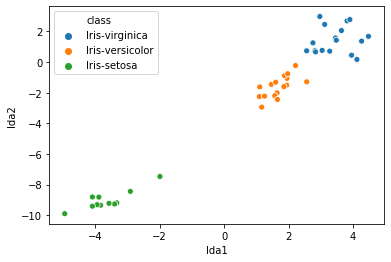

In [11]:
ax = sns.scatterplot(x="lda1", y="lda2", hue="class", data=test)

## P2 : MUSHROOM information gain

### Take the MUSHROOM training data. There are 20+ features and 2 classes. We want to find the BEST feature using the three purity measures: Accuracy, Gini Index, and Entropy.

In [12]:
col_names = ['class',
             'cap-shape',
             'cap-surface',
             'cap-color',
             'bruises',
             'odor',
             'gill-attachment',
             'gill-spacing',
             'gill-size',
             'gill-color',
             'stalk-shape',
             'stalk-root',
             'stalk-surface-above-ring',
             'stalk-surface-below-ring',
             'stalk-color-above-ring',
             'stalk-color-below-ring',
             'veil-type',
             'veil-color',
             'ring-number',
             'ring-type',
             'spore-print-color',
             'population',
             'habitat']
mushroom = pd.read_csv('DMG-2 Assignment Data Files/Mushroom/agaricus-lepiota.data',
                       index_col=None,
                       header=None,
                       names=col_names)
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Logic Used to Answer : For each feature, partition the data into k regions where k is the number of values the feature can take.

- Take one feature at a time from dataframe
- create a subset of data with that feature and class labels
- Groupby count to partition data into K features where k is no of values feature can take

### Measure the Information gain due to each feature. Generate a table with the following columns:
- Feature_name
- Accuracy
- GINI index
- Entropy (NOTE: Use log_k for a feature with k values)

In [13]:
#define a empty dataframe for result set
result_set = pd.DataFrame(columns = ['Feature', 'Accuracy', 'Gini', '1-Entropy'])
result_set

,Feature,Accuracy,Gini,1-Entropy


In [14]:
#No. of rows
total_rows_data = mushroom.shape[0]

for column in col_names[1:] :
    df_feature_subset = mushroom[[column,'class']]
    feature_partition = df_feature_subset.groupby([column,'class']).size().unstack(fill_value=0)
    
    #Ref : https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb
    for index, row in feature_partition.iterrows():
        partition_total_sum = row['e'] + row['p']
        prob_e_class = row['e']/partition_total_sum
        prob_p_class = row['p']/partition_total_sum

        # calculate accuracy for each partition
        if(row['e'] > row['p']) :
            feature_partition.at[index,'Parition Accuracy'] = prob_e_class
        else :
            feature_partition.at[index,'Parition Accuracy'] = prob_p_class
        feature_partition.at[index,'Weighted Accuracy'] = partition_total_sum*feature_partition.loc[index,'Parition Accuracy']/total_rows_data

        #calculate gini index for each partition
        feature_partition.at[index,'Gini Index'] = prob_e_class**2 + prob_p_class**2
        feature_partition.at[index,'Weighted Gini Index'] = partition_total_sum*feature_partition.loc[index,'Gini Index']/total_rows_data

        #calculate entropy for each partition
        entropy = 0
        num_of_partitions = feature_partition.shape[0]
        if(num_of_partitions > 1) :
            #print(num_of_partitions)
            if(prob_e_class > 0) :
                entropy += prob_e_class*math.log(prob_e_class, num_of_partitions)
            if(prob_p_class > 0) :
                entropy += prob_p_class*math.log(prob_p_class, num_of_partitions)
        feature_partition.at[index,'Entropy'] = -1*entropy
        feature_partition.at[index,'Weighted Entropy'] = partition_total_sum*feature_partition.loc[index,'Entropy']/total_rows_data
    print()
    print(feature_partition)
    
    result_set = result_set.append({'Feature' : column, 
                       'Accuracy': feature_partition[['Weighted Accuracy']].sum()[0].round(4),
                       'Gini' : feature_partition[['Weighted Gini Index']].sum()[0].round(4),
                       '1-Entropy': 1-feature_partition[['Weighted Entropy']].sum()[0].round(4)}, ignore_index=True)
    
result_set.head()


class         e     p  Parition Accuracy  Weighted Accuracy  Gini Index  \
cap-shape                                                                 
b           404    48           0.893805           0.049729    0.810165   
c             0     4           1.000000           0.000492    1.000000   
f          1596  1556           0.506345           0.196455    0.500081   
k           228   600           0.724638           0.073855    0.600924   
s            32     0           1.000000           0.003939    1.000000   
x          1948  1708           0.532823           0.239783    0.502155   

class      Weighted Gini Index   Entropy  Weighted Entropy  
cap-shape                                                   
b                     0.045076  0.188912          0.010511  
c                     0.000492 -0.000000         -0.000000  
f                     0.194024  0.386808          0.150076  
k                     0.061246  0.328459          0.033477  
s                     0.003939 -

p                     0.500646      0.0               0.0  

class          e     p  Parition Accuracy  Weighted Accuracy  Gini Index  \
veil-color                                                                 
n             96     0           1.000000           0.011817    1.000000   
o             96     0           1.000000           0.011817    1.000000   
w           4016  3908           0.506815           0.494338    0.500093   
y              0     8           1.000000           0.000985    1.000000   

class       Weighted Gini Index   Entropy  Weighted Entropy  
veil-color                                                   
n                      0.011817 -0.000000         -0.000000  
o                      0.011817 -0.000000         -0.000000  
w                      0.487781  0.499933          0.487625  
y                      0.000985 -0.000000         -0.000000  

class           e     p  Parition Accuracy  Weighted Accuracy  Gini Index  \
ring-number                     

,Feature,Accuracy,Gini,1-Entropy
0,cap-shape,0.5643,0.5308,0.6324
1,cap-surface,0.5805,0.5200,0.5148
2,cap-color,0.5953,0.5245,0.7101
3,bruises,0.7440,0.6262,0.1933
4,odor,0.9852,0.9715,0.9707


In [15]:
result_set.tail()

,Feature,Accuracy,Gini,1-Entropy
17,ring-number,0.5382,0.5237,0.3939
18,ring-type,0.7755,0.6824,0.7067
19,spore-print-color,0.8680,0.7835,0.8365
20,population,0.7218,0.6193,0.6916
21,habitat,0.6903,0.5974,0.7000


### Plot accuracy vs. 1-Entropy scatter plot where each point is a feature.

We can see that Accuracy and '1-Entropy' are curvi linear, as Accuracy increases '1-Entropy' also increases for that feature, however there are 5 features which are outlier to this trend

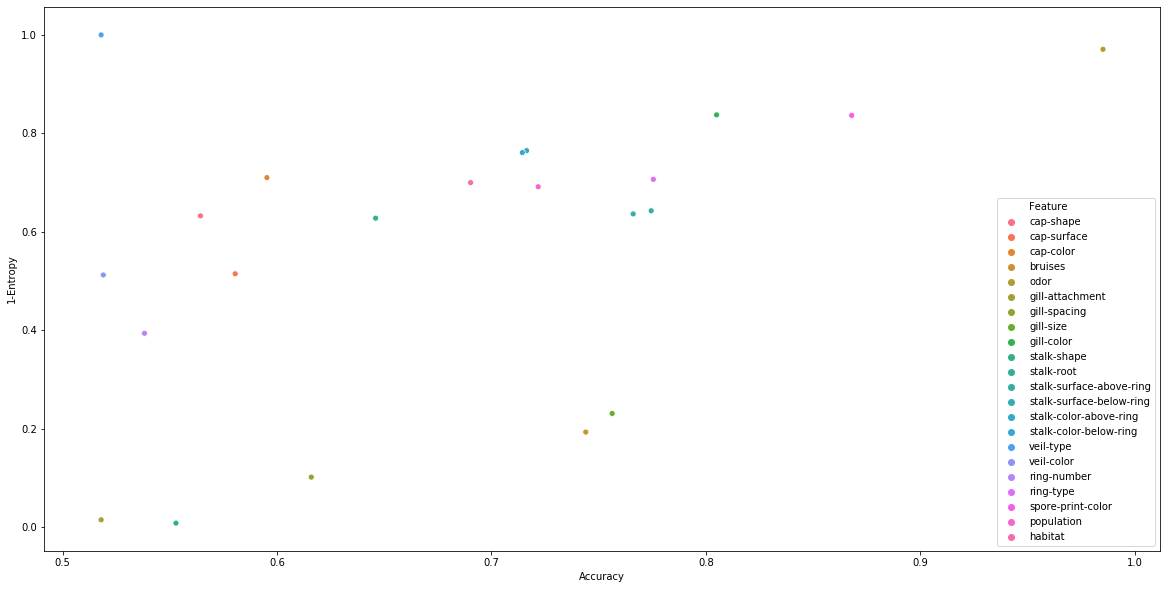

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x='Accuracy', y='1-Entropy', hue='Feature', data=result_set)

### veil-type, odor, gill-color, spore-print-color are top features which alone can define the whole data

In [17]:
result_set.sort_values(by='1-Entropy', ascending=False)

,Feature,Accuracy,Gini,1-Entropy
15,veil-type,0.5180,0.5006,1.0000
4,odor,0.9852,0.9715,0.9707
8,gill-color,0.8050,0.7321,0.8376
19,spore-print-color,0.8680,0.7835,0.8365
13,stalk-color-above-ring,0.7164,0.6382,0.7649
14,stalk-color-below-ring,0.7144,0.6329,0.7610
2,cap-color,0.5953,0.5245,0.7101
18,ring-type,0.7755,0.6824,0.7067
21,habitat,0.6903,0.5974,0.7000
20,population,0.7218,0.6193,0.6916


## P3 : MUSHROOM NB/DT

In [18]:
col_names = ['class',
             'cap-shape',
             'cap-surface',
             'cap-color',
             'bruises',
             'odor',
             'gill-attachment',
             'gill-spacing',
             'gill-size',
             'gill-color',
             'stalk-shape',
             'stalk-root',
             'stalk-surface-above-ring',
             'stalk-surface-below-ring',
             'stalk-color-above-ring',
             'stalk-color-below-ring',
             'veil-type',
             'veil-color',
             'ring-number',
             'ring-type',
             'spore-print-color',
             'population',
             'habitat']
mushroom = pd.read_csv('DMG-2 Assignment Data Files/Mushroom/agaricus-lepiota.data',
                       index_col=None,
                       header=None,
                       names=col_names)
mushroom.head()

X = mushroom.loc[:, mushroom.columns != 'class']
X = pd.get_dummies(X)
y = mushroom.loc[:, mushroom.columns == 'class']

### Build Naive Bayes and Decision Tree classifiers on the MUSHROOM training dataset.

In [19]:
#use a classic 70:30 split ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11915043)

df = pd.DataFrame(columns=['lambda','accuracy', 'type'])
for i in range(0,51) :
    nbc = BernoulliNB(alpha=i)
    nbc.fit(X_train, y_train.values.ravel())
    train_score = accuracy_score(y_train, nbc.predict(X_train))
    test_score = accuracy_score(y_test, nbc.predict(X_test))
    df = df.append({'lambda' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
    df = df.append({'lambda' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
    print(i, train_score, test_score)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0 0.9943721421034118 0.9967186218211649
1 0.9395005276116778 0.9364232977850697
2 0.934048540274358 0.9306808859721083
3 0.9305311290889905 0.9290401968826907
4 0.9287724234963067 0.9245283018867925
5 0.9277172001406965 0.9232977850697293
6 0.9264861062258178 0.9216570959803118
7 0.9252550123109391 0.9212469237079574
8 0.9243756595145972 0.9191960623461854
9 0.923320436158987 0.9175553732567678
10 0.9220893422441083 0.9163248564397046
11 0.9215617305663032 0.9150943396226415
12 0.9208582483292297 0.9138638228055783
13 0.9201547660921562 0.9134536505332239
14 0.9192754132958143 0.9118129614438064
15 0.9187478016180092 0.9105824446267432
16 0.918220189940204 0.9101722723543888
17 0.9171649665845938 0.9101722723543888
18 0.9169890960253254 0.9097621000820345
19 0.9166373549067885 0.9097621000820345
20 0.9164614843475202 0.9089417555373257
21 0.9157580021104467 0.9089417555373257
22 0.9152303904326415 0.9089417555373257
23 0.9147027787548364 0.9085315832649713
24 0.914526908195568 0.908121

### In Naïve Bayes classifier plot the value of lambda (x axis) for Laplacian smoothing against training and test set accuracy.

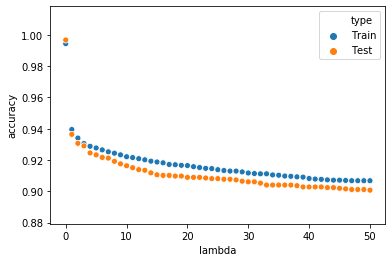

In [20]:
x = sns.scatterplot(x="lambda", y='accuracy', hue='type', data=df)

### For decision tree classifier plot the Size Threshold (x axis) against training and test set accuracy.

In [21]:
df = pd.DataFrame(columns=['size threshold','accuracy', 'type'])
for i in range(4,65,4) :
    dtc = DecisionTreeClassifier(min_samples_split=i)
    dtc.fit(X_train, y_train)
    train_score = accuracy_score(y_train, dtc.predict(X_train))
    test_score = accuracy_score(y_test, dtc.predict(X_test))
    df = df.append({'size threshold' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
    df = df.append({'size threshold' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
    print(i, train_score, test_score)

4 1.0 1.0
8 1.0 1.0
12 1.0 1.0
16 1.0 1.0
20 1.0 1.0
24 1.0 1.0
28 1.0 1.0
32 1.0 1.0
36 1.0 1.0
40 0.9982412944073162 0.9975389663658737
44 0.9982412944073162 0.9975389663658737
48 0.9982412944073162 0.9975389663658737
52 0.9982412944073162 0.9975389663658737
56 0.9982412944073162 0.9975389663658737
60 0.9982412944073162 0.9975389663658737
64 0.9982412944073162 0.9975389663658737


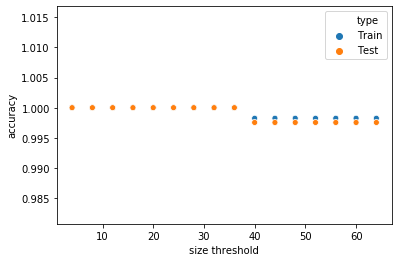

In [22]:
ax = sns.scatterplot(x="size threshold", y='accuracy', hue='type', data=df)
#ax.set_xticks(range(0,68,4))

### Find the best values of lambda and SizeThreshold where the test set accuracies starts to decrease.

In [23]:
#Get summary of best tree at threshold of 36
dtc = DecisionTreeClassifier(min_samples_split=36)
dtc.fit(X_train, y_train)
dtc.get_depth()

7

Looking at plots above, we can say -

- Naive Bayes - Even with very small lambda value for smoothening we are getting best accuracy, ie lambda- 1.0e-10, since 0 is numerically not possible. The next best is lambda = 1
- Decision Tree Classifier - Best size threshold : 36
    
Comparision -
- Naive bayes classifier are surprisingly giving better result on set set as lambda increases, compared to train set which creates doubt.
- Decision Tree Classifier are performing better than Naive Bayes with a test set accuracy of 1 at size threshold of 36, just a depth of 8.

## P4 : MNIST Bayesian

### Take the MNIST dataset. Lets call it D0 dataset

In [24]:
mnist = pd.read_csv('DMG-2 Assignment Data Files/MNIST/train.csv')
mnist.head()

mnist_data = mnist.loc[:, mnist.columns != 'label']
mnist_label = mnist.loc[:, mnist.columns == 'label']

In [25]:
target_names = pd.Series(mnist.label.unique()).apply(str)
print(target_names)
n_components = 9

0    1
1    0
2    4
3    7
4    3
5    5
6    8
7    9
8    2
9    6
dtype: object


### Do a 9 dimensional PCA projection . Lets call it D1 dataset

In [26]:
pca = decomposition.PCA()
pca.n_components = n_components
pca_data = pca.fit_transform(mnist_data)

### Do a 9 dimensional FISHER projection . Lets call it D2 dataset

In [27]:
model = LinearDiscriminantAnalysis(n_components=n_components)
model.fit(mnist_data, mnist_label.values.ravel())
mnist_fisher_proj_data = model.transform(mnist_data)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### Build a Bayesian classifier on D1 (single Gaussian per class)
- Diagonal Covariance matrix ( i.e.set non diagonals to zero)
- Full Covariance matrix

Ref :
#https://stats.stackexchange.com/questions/105140/gaussian-naive-bayes-really-equivalent-to-gmm-with-diagonal-covariance-matrices
#https://scikit-learn.org/stable/modules/mixture.html#bgmm
#https://www.programcreek.com/python/example/99731/sklearn.mixture.BayesianGaussianMixture


In [28]:
def build_classifier(X_train, X_test, y_train, y_test, n_gaussians, target_names) :
    
    #Build bayesian classifier with diagnonal covariance matrix on fisher projection data
    gnb_model = GaussianNB()
    gnb_model.fit(X_train, y_train)
    y_pred = gnb_model.predict(X_test)
    nb_diag_acc = accuracy_score(y_test, y_pred)
    print("Gaussian Naive Bayes diagonal matrix : ")
    print("Train set accuracy score : ", accuracy_score(y_test, y_pred))
    print("Test set accuracy score : ", nb_diag_acc)
    print("Classification report : ")
    print(classification_report(y_test, y_pred, target_names=target_names))

    #Build bayesian classifier with full covariance matrix on fisher projection data
    bgm = BayesianGaussianMixture(
                n_components = n_gaussians,
                covariance_type='full')
    bgm.fit(X_train, y_train)
    y_pred = bgm.predict(X_test)
    #print(y_pred)
    #print(y_test)
    b_full_acc = accuracy_score(y_test, y_pred)
    print("\nBayesian Gaussian mixture full covariance matrix : ")
    print("Train set accuracy : ", accuracy_score(y_test, y_pred))
    print("Test set accuracy : ", b_full_acc)
    print("Classification report : ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    #return test accuracies of both model
    return nb_diag_acc, b_full_acc

In [29]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, mnist['label'], test_size=0.2, random_state=11915043)
print(build_classifier(X_train, X_test, y_train, y_test, 10, target_names))

Gaussian Naive Bayes diagonal matrix : 
Train set accuracy score :  0.756547619047619
Test set accuracy score :  0.756547619047619
Classification report : 
              precision    recall  f1-score   support

           1       0.89      0.83      0.86       827
           0       0.85      0.92      0.88       931
           4       0.83      0.74      0.78       865
           7       0.72      0.72      0.72       844
           3       0.64      0.69      0.66       814
           5       0.57      0.65      0.61       720
           8       0.87      0.84      0.86       851
           9       0.86      0.82      0.84       915
           2       0.70      0.73      0.72       806
           6       0.63      0.59      0.61       827

    accuracy                           0.76      8400
   macro avg       0.76      0.75      0.75      8400
weighted avg       0.76      0.76      0.76      8400


Bayesian Gaussian mixture full covariance matrix : 
Train set accuracy :  0.06119047

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


### Build a Bayesian classifier on D2 (single Gaussian per class)
- Diagonal Covariance matrix ( i.e.set non diagonals to zero)
- Full Covariance matrix

In [30]:
X_train, X_test, y_train, y_test = train_test_split(mnist_fisher_proj_data, mnist['label'], test_size=0.2, 
                                                    random_state = 11915043)
print(build_classifier(X_train, X_test, y_train, y_test, 10, target_names))

Gaussian Naive Bayes diagonal matrix : 
Train set accuracy score :  0.8776190476190476
Test set accuracy score :  0.8776190476190476
Classification report : 
              precision    recall  f1-score   support

           1       0.95      0.93      0.94       827
           0       0.94      0.92      0.93       931
           4       0.86      0.86      0.86       865
           7       0.88      0.84      0.86       844
           3       0.90      0.88      0.89       814
           5       0.80      0.84      0.82       720
           8       0.93      0.91      0.92       851
           9       0.92      0.87      0.90       915
           2       0.77      0.83      0.80       806
           6       0.82      0.88      0.85       827

    accuracy                           0.88      8400
   macro avg       0.88      0.88      0.88      8400
weighted avg       0.88      0.88      0.88      8400


Bayesian Gaussian mixture full covariance matrix : 
Train set accuracy :  0.025595

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


### Compare the test accuracies of the four classifiers and comment.

diagonal covariance matrix - 
- PCA projection - test set accuracy is 0.76
- Fisher projection - test set accuracy is 0.88

If we look at classification matrix for test set, we see that on PCA data, digits 7,3,5 are performing poorly which improves with flscore of 0.83-0.9 range when doing classification modeling on fisher projection data


full covariance matrix - 
- PCA projection - test set accuracy is 0.019
- Fisher projection - test set accuracy is 0.108

## P5 : MNIST KNN / Parzen window

### Take the two datasets D1 and D2 from P4.

### Build k Nearest neighbors classifier with:
- K = 1, 3, 5, 7, 9, 11, 13, 15, 17
- Plot training and test accuracy with these values of k on x axis

In [31]:
def build_knn(X_train, X_test, y_train, y_test) :
    df = pd.DataFrame(columns=['k','accuracy', 'type'])
    for i in range(1,18,2) :
        knn_model = KNeighborsClassifier(n_neighbors=i)
        knn_model.fit(X_train, y_train)
        train_score = round(accuracy_score(y_train, knn_model.predict(X_train)),4)
        test_score = round(accuracy_score(y_test, knn_model.predict(X_test)),4)
        df = df.append({'k' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
        df = df.append({'k' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
        print(i, train_score, test_score)
    return df

#### kNN on PCA data (D1)

1 1.0 0.8894
3 0.9487 0.8987
5 0.9382 0.9067
7 0.9329 0.9111
9 0.9281 0.911
11 0.9253 0.9094
13 0.9222 0.9081
15 0.921 0.9082
17 0.9185 0.9093


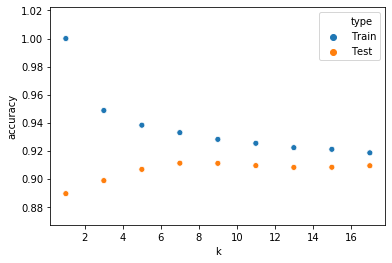

In [32]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, mnist['label'], test_size=0.2, 
                                                    random_state=11915043)
df = build_knn(X_train, X_test, y_train, y_test)
sns.scatterplot(x="k", y='accuracy', hue='type', data=df)

#### kNN on fisher projection data (D2)

1 1.0 0.8989
3 0.9478 0.9124
5 0.9388 0.915
7 0.9339 0.9164
9 0.9315 0.9145
11 0.9287 0.9144
13 0.9277 0.9149
15 0.9262 0.9129
17 0.9251 0.9135


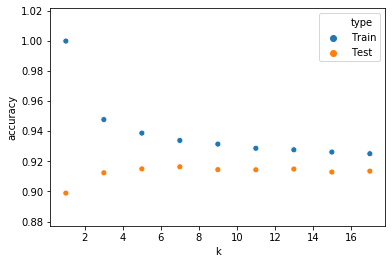

In [33]:
X_train, X_test, y_train, y_test = train_test_split(mnist_fisher_proj_data, mnist['label'], test_size=0.2, 
                                                    random_state=11915043)
df = build_knn(X_train, X_test, y_train, y_test)
sns.scatterplot(x="k", y='accuracy', hue='type', data=df)

### Build Parzen window classifier with:
- Sigma = 0.1, 0.2, 0.3, …, 3.0
- Plot training and test accuracies with these values of sigma.

In [34]:
sigma_list = []
for i in np.arange(0.1, 3.1, 0.1) :
    sigma_list.append(round(i,1))
classes = np.sort(y_train.unique())

def predict_accuracy(kde_models, X) :
    predict_accuracy = 0
    for model in kde_models :
        log_prob = model.score_samples(X)
        prob_X = np.sum(np.exp(log_prob))
        if(prob_X > predict_accuracy) :
            predict_accuracy = prob_X
    return predict_accuracy

#Adapted from : https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
def build_parzen_classifier(X_train, X_test, y_train, y_test) :
    df = pd.DataFrame(columns=['sigma','accuracy', 'type'])
    for i in sigma_list :
        kde_models = []
        for class_label in classes :
            #print("kde for class : ", class_label)
            X = pca_data[mnist[mnist['label']==class_label].index]
            kde_model = KernelDensity(bandwidth=i, kernel='gaussian')
            kde_model.fit(X)
            kde_models.append(kde_model)
        train_score = predict_accuracy(kde_models, X_train)
        test_score = predict_accuracy(kde_models, X_test)
        
        df = df.append({'sigma' : i,'accuracy':train_score, 'type': 'Train'}, ignore_index=True)
        df = df.append({'sigma' : i,'accuracy':test_score, 'type': 'Test'}, ignore_index=True)
        print(i, train_score, test_score)
    return df

0.1 207607.48127078288 53865.39944951355
0.2 405.4833618569984 105.2058582998312
0.3 10.547552775023314 2.7366458085410637
0.4 0.7919596911269542 0.20548019199185866
0.5 0.10629503041064162 0.027579084518151026
0.6 0.020600689013717505 0.005345011344806806
0.7 0.005144706922253201 0.0013348348128957663
0.8 0.0015467962717323404 0.00040132849998410116
0.9 0.0005358711972272217 0.00013903601120464769
1.0 0.00020760748127078625 5.386539944951453e-05
1.1 8.804583836325039e-05 2.284418761922161e-05
1.2 4.023572072991727e-05 1.0439475282825914e-05
1.3 1.957730148010321e-05 5.079485372658026e-06
1.4 1.0048255707525901e-05 2.607099243937088e-06
1.5 5.4003470208120425e-06 1.4011626539730568e-06
1.6 3.0210864682272507e-06 7.838447265314619e-07
1.7 1.7506636209649984e-06 4.542234926592855e-07
1.8 1.0466234320844248e-06 2.7155470938408513e-07
1.9 6.433696812729857e-07 1.6692734126606283e-07
2.0 4.0548336185700884e-07 1.0520585829983457e-07
2.1 2.6137819043099633e-07 6.781663429841994e-08
2.2 1.719

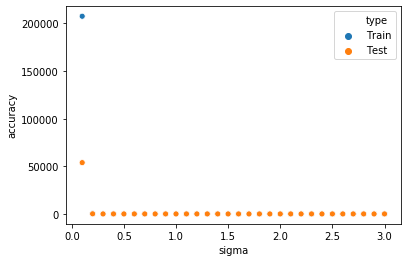

In [35]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, mnist['label'], test_size=0.2)
df = build_parzen_classifier(X_train, X_test, y_train, y_test)
sns.scatterplot(x="sigma", y='accuracy', hue='type', data=df)

0.1 0 0
0.2 2.1752105268263355e-155 0
0.3 2.689410168650887e-78 3.3933760029872144e-76
0.4 5.167705303549493e-47 2.8339405229216806e-50
0.5 5.356321942593302e-35 2.0741273381412824e-36
0.6 6.090299730156047e-28 1.2564696751956942e-28
0.7 1.9833720289582778e-24 5.821066248771212e-25
0.8 1.044703485742745e-22 2.800707136550076e-23
0.9 6.612105843952949e-21 1.6972442026723287e-21
1.0 2.2975123454076482e-20 5.9361953901670496e-21
1.1 4.750159232594671e-20 1.2086254193209371e-20
1.2 1.0255971294303331e-19 2.1481388563209358e-20
1.3 1.1320860398725435e-19 2.922963172492722e-20
1.4 9.540603576768931e-20 2.3938563385109085e-20
1.5 6.663863087528497e-20 1.6645402346820223e-20
1.6 4.675059711323352e-20 1.1879068272868309e-20
1.7 3.2177443458155434e-20 8.123941088589632e-21
1.8 2.2437413463061384e-20 5.796967479719207e-21
1.9 1.5403970919143272e-20 3.845776914008781e-21
2.0 1.0293767273075196e-20 2.559637423884564e-21
2.1 7.022007467041681e-21 1.7466196215580522e-21
2.2 4.764345435394489e-21 1.18

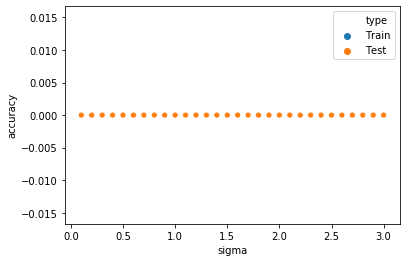

In [36]:
X_train, X_test, y_train, y_test = train_test_split(mnist_fisher_proj_data, mnist['label'], 
                                                    test_size=0.2, random_state=11915043)
df = build_parzen_classifier(X_train, X_test, y_train, y_test)
sns.scatterplot(x="sigma", y='accuracy', hue='type', data=df)

## P6 : News group Text Classifier

In [37]:
#check sample of categories and document nos.
#This file doesn't seem to be of any use, as all document Ids belong to same newsgroup
categories = pd.read_csv("DMG-2 Assignment Data Files/Newsgroup/list.csv")
categories.sample(5)

,newsgroup,document_id
260,talk.religion.misc,83911
171,talk.religion.misc,83677
391,talk.religion.misc,84151
106,talk.religion.misc,83513
378,talk.religion.misc,84138


In [38]:
#Ref :
#https://stackoverflow.com/questions/35672809/how-to-read-a-list-of-txt-files-in-a-folder-in-python
#https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
#https://medium.com/@dobko_m/nlp-text-data-cleaning-and-preprocessing-ea3ffe0406c1
#https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925
#https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
#https://github.com/gokriznastic/20-newsgroups_text-classification/blob/master/Multinomial%20Naive%20Bayes-%20BOW%20with%20TF.ipynb


#Read all documents one by one and create two dataframes
#One for finding probability and other for running naive bayes

df = pd.DataFrame(columns=['data','document'])
df_docs = pd.DataFrame(columns=['doc part','document'])
text_files = glob.glob("DMG-2 Assignment Data Files/Newsgroup/*.txt")

#read all text files and create a dataframe of whole dataset
for file in text_files :
    print("Reading file : ", file)
    category = file[file.rfind('/')+1:-4]
    with open(file, 'r', encoding='windows-1252') as current_file :
        data = current_file.read()
        df = df.append({'data':data, 'document': category}, ignore_index=True)
        
        #split each file at \n to create multiple documents from each data
        #this dataset will be used for naive bayes
        docs = data.split('\n\n')
        df_temp = pd.DataFrame(docs, columns=['doc part'])
        df_temp['document'] = category
        df_docs = df_docs.append(df_temp, ignore_index=True)
        
df.sample(5)

Reading file :  DMG-2 Assignment Data Files/Newsgroup/sci.crypt.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/comp.sys.mac.hardware.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/misc.forsale.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/soc.religion.christian.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/rec.sport.baseball.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/rec.sport.hockey.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/comp.sys.ibm.pc.hardware.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/talk.politics.guns.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/rec.autos.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/alt.atheism.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/comp.os.ms-windows.misc.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/sci.electronics.txt
Reading file :  DMG-2 Assignment Data Files/Newsgroup/comp.windows.x.txt
Reading file :  DMG-2

,data,document
9,From: mathew <mathew@mantis.co.uk>\nSubject: A...,alt.atheism
3,Newsgroup: soc.religion.christian\ndocument_id...,soc.religion.christian
16,Newsgroup: rec.motorcycles\ndocument_id: 10172...,rec.motorcycles
1,Newsgroup: comp.sys.mac.hardware\ndocument_id:...,comp.sys.mac.hardware
0,Newsgroup: sci.crypt\ndocument_id: 14147\nFrom...,sci.crypt


In [39]:
stop_words = stopwords.words('english')

#important to add email ids to remove training bias, as documents contain emails from specific sources
stop_words.extend(["Newsgroup","document_id","From","Subject","document","umd","edu","wam","mri","com"])

'''
Return cleaned array of words from data
'''
def clean_get_words(data, tokenize=False) :
    # replace all non alphabetical characters with space
    data = re.sub("[^a-zA-Z]", ' ', data)
    
    #convert data to lowercase
    data = data.lower()
    
    # remove all words less than 3 characters
    data = re.sub(r'\b\w{1,2}\b', '', data)
    
    # get all unique words from data
    words = re.sub("[^\w]", " ",  data).split()
    words = [word for word in words if word not in stop_words]
    
    #stemming at per DMG2 session 5 explaination before building NLP
    lancaster = LancasterStemmer()
    data = " ".join(words)
    lancaster.stem(data)
    
    #tokenize words are used during naive bayes
    if(tokenize) :
        return data.split(" ")
    
    return data

#### Build a Naïve Bayes Classifier on Newsgroup dataset

### DICTIONARY :
- Compute the document frequency of all words (how many documents each word occurred in)
- Sort this in descending order of document frequency
- Pick the top 5000 and 10000 words as the dictionary.

In [40]:
%%time

#clean each of the documents and get words from it
df['data'] = df['data'].map(clean_get_words)
#get unique words from each document
df['unique words data'] = df['data'].apply(lambda x: " ".join(set(x.split(' '))))

#create a count vector to create top 5k and 10k words
countVectorizer = CountVectorizer()
count_vec = countVectorizer.fit_transform(df['unique words data'])
word2vec = pd.DataFrame(count_vec.toarray(), columns=countVectorizer.get_feature_names())

CPU times: user 24.7 s, sys: 978 ms, total: 25.6 s
Wall time: 25.7 s


#### Compute the document frequency of all words (how many documents each word occurred in)

In [41]:
word2vec.index = df.document
word2vec.sample(5)

,aaa,aaaa,aaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaaaagggghhhh,aaaaarrrrgh,aaaahhh,aaaall,aaaarrgghhhh,...,zztop,zzum,zzvsi,zzx,zzy,zzz,zzzoh,zzzz,zzzzzz,zzzzzzt
document,,,,,,,,,,,,,,,,,,,,,
comp.os.ms-windows.misc,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,1,0,1,0,0,0
rec.sport.baseball,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
comp.windows.x,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
soc.religion.christian,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
talk.politics.mideast,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Dictionary : Sort this in descending order of document frequency

In [42]:
sum_matrix = word2vec.sum(axis=0)
term_document_frequency = sum_matrix.sort_values(ascending=False)

#### Dictionary : Pick the top 5000 and 10000 words as the dictionary.

In [43]:
top_5k = term_document_frequency[:5000]
print(top_5k)
print()
top_10k = term_document_frequency[:10000]
print(top_10k)

offer             20
third             20
world             20
later             20
late              20
                  ..
eve               13
rank              13
anon              13
ranks             13
specifications    13
Length: 5000, dtype: int64

offer          20
third          20
world          20
later          20
late           20
               ..
perpetuate      7
api             7
listings        7
clay            7
diagnostics     7
Length: 10000, dtype: int64


#### Learn P( w|c ) for all words and classes

Done it for top 10k and top 5k words only

In [44]:
#get all words in a given document, difference from above is set()
df['words'] = df['data'].apply(lambda x: " ".join(x.split(' ')))

#create a count vector to calculate probability of each word in given document(class)
countVectorizer = CountVectorizer()
count_vec = countVectorizer.fit_transform(df['words'])
word2vec = pd.DataFrame(count_vec.toarray(), columns=countVectorizer.get_feature_names())

#Take only top 5k and 10k words

word2vec_5k = word2vec[list(top_5k.index)]
word2vec_5k.index = df.document

word2vec_10k = word2vec[list(top_10k.index)]
word2vec_10k.index = df.document
word2vec_10k

,offer,third,world,later,late,upon,last,difference,works,different,...,slides,escaping,perot,evolving,depletion,perpetuate,api,listings,clay,diagnostics
document,,,,,,,,,,,,,,,,,,,,,
sci.crypt,34,60,232,94,68,92,186,90,82,202,...,0,0,0,4,0,2,10,0,0,0
comp.sys.mac.hardware,46,78,102,48,18,28,172,150,208,132,...,2,0,0,0,0,0,2,0,0,2
misc.forsale,668,12,130,14,18,24,128,12,144,28,...,0,0,0,0,0,0,2,0,4,8
soc.religion.christian,58,86,648,206,62,238,322,162,202,486,...,2,0,0,2,0,0,0,2,8,0
rec.sport.baseball,26,272,234,74,86,22,964,86,28,120,...,0,0,2,0,6,0,0,0,18,0
rec.sport.hockey,28,296,252,106,114,24,736,54,32,126,...,0,4,0,0,0,0,0,2,4,0
comp.sys.ibm.pc.hardware,34,66,74,58,6,20,172,144,232,182,...,0,0,0,0,0,0,0,0,0,16
talk.politics.guns,32,50,204,160,70,88,318,150,64,230,...,0,4,0,2,2,2,0,0,6,0
rec.autos,70,44,144,128,60,18,270,86,96,184,...,0,0,0,0,6,0,0,0,0,2


In [45]:
#total no. of words in each document
word2vec_5k.loc[:,"sum"] = word2vec_5k.sum(axis=1)

#calculate probability P(w|C) for all words across all classes
df_prob = word2vec_5k.loc[:, word2vec_5k.columns != 'sum'].div(word2vec_5k.loc[:,"sum"], axis=0)
df_prob

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,offer,third,world,later,late,upon,last,difference,works,different,...,exclude,modules,mate,excluded,solving,eve,rank,anon,ranks,specifications
document,,,,,,,,,,,,,,,,,,,,,
sci.crypt,0.000134,0.000236,0.000913,0.000370,0.000268,0.000362,0.000732,0.000354,0.000323,0.000795,...,0.000008,0.000008,0.000024,0.000000,0.000031,0.000142,0.000008,0.000394,0.000000,0.000087
comp.sys.mac.hardware,0.000331,0.000562,0.000735,0.000346,0.000130,0.000202,0.001239,0.001081,0.001499,0.000951,...,0.000014,0.000043,0.000000,0.000000,0.000014,0.000014,0.000058,0.000000,0.000029,0.000101
misc.forsale,0.006167,0.000111,0.001200,0.000129,0.000166,0.000222,0.001182,0.000111,0.001329,0.000259,...,0.000000,0.000018,0.000018,0.000018,0.000055,0.000203,0.000000,0.000000,0.000000,0.000074
soc.religion.christian,0.000213,0.000315,0.002376,0.000755,0.000227,0.000873,0.001181,0.000594,0.000741,0.001782,...,0.000095,0.000015,0.000037,0.000059,0.000007,0.000213,0.000000,0.000000,0.000007,0.000007
rec.sport.baseball,0.000153,0.001604,0.001380,0.000436,0.000507,0.000130,0.005684,0.000507,0.000165,0.000708,...,0.000000,0.000000,0.000012,0.000012,0.000000,0.000000,0.000094,0.000012,0.000024,0.000024
rec.sport.hockey,0.000152,0.001606,0.001367,0.000575,0.000618,0.000130,0.003992,0.000293,0.000174,0.000683,...,0.000011,0.000000,0.000000,0.000000,0.000000,0.000011,0.000076,0.000000,0.000011,0.000000
comp.sys.ibm.pc.hardware,0.000226,0.000439,0.000492,0.000385,0.000040,0.000133,0.001143,0.000957,0.001542,0.001209,...,0.000013,0.000013,0.000000,0.000000,0.000013,0.000000,0.000013,0.000000,0.000013,0.000186
talk.politics.guns,0.000137,0.000213,0.000871,0.000683,0.000299,0.000376,0.001357,0.000640,0.000273,0.000982,...,0.000000,0.000000,0.000009,0.000000,0.000017,0.000009,0.000043,0.000068,0.000043,0.000000
rec.autos,0.000436,0.000274,0.000898,0.000798,0.000374,0.000112,0.001684,0.000536,0.000599,0.001147,...,0.000012,0.000012,0.000012,0.000062,0.000050,0.000025,0.000000,0.000000,0.000000,0.000037


In [46]:
#total no. of words in each document
word2vec_10k.loc[:,"sum"] = word2vec_10k.sum(axis=1)

#calculate probability P(w|C) for all words across all classes
df_prob = word2vec_10k.loc[:, word2vec_10k.columns != 'sum'].div(word2vec_10k.loc[:,"sum"], axis=0)
df_prob

,offer,third,world,later,late,upon,last,difference,works,different,...,slides,escaping,perot,evolving,depletion,perpetuate,api,listings,clay,diagnostics
document,,,,,,,,,,,,,,,,,,,,,
sci.crypt,0.000117,0.000206,0.000798,0.000323,0.000234,0.000316,0.000640,0.000309,0.000282,0.000695,...,0.000000,0.000000,0.000000,0.000014,0.000000,0.000007,0.000034,0.000000,0.000000,0.000000
comp.sys.mac.hardware,0.000295,0.000500,0.000654,0.000308,0.000115,0.000180,0.001103,0.000962,0.001334,0.000846,...,0.000013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000013,0.000000,0.000000,0.000013
misc.forsale,0.005325,0.000096,0.001036,0.000112,0.000143,0.000191,0.001020,0.000096,0.001148,0.000223,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.000000,0.000032,0.000064
soc.religion.christian,0.000185,0.000274,0.002064,0.000656,0.000197,0.000758,0.001026,0.000516,0.000643,0.001548,...,0.000006,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000006,0.000025,0.000000
rec.sport.baseball,0.000138,0.001443,0.001242,0.000393,0.000456,0.000117,0.005115,0.000456,0.000149,0.000637,...,0.000000,0.000000,0.000011,0.000000,0.000032,0.000000,0.000000,0.000000,0.000096,0.000000
rec.sport.hockey,0.000133,0.001405,0.001196,0.000503,0.000541,0.000114,0.003494,0.000256,0.000152,0.000598,...,0.000000,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000019,0.000000
comp.sys.ibm.pc.hardware,0.000199,0.000386,0.000433,0.000340,0.000035,0.000117,0.001007,0.000843,0.001359,0.001066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094
talk.politics.guns,0.000118,0.000184,0.000751,0.000589,0.000258,0.000324,0.001170,0.000552,0.000236,0.000847,...,0.000000,0.000015,0.000000,0.000007,0.000007,0.000007,0.000000,0.000000,0.000022,0.000000
rec.autos,0.000387,0.000243,0.000796,0.000707,0.000332,0.000099,0.001492,0.000475,0.000531,0.001017,...,0.000000,0.000000,0.000000,0.000000,0.000033,0.000000,0.000000,0.000000,0.000000,0.000011


#### To run naive bayes, I have taken the whole dataset in original and do test train split
##### This Original document dataset is divided such that each new line is considered as new document (created above)

In [47]:
%%time

#drop all rows which doesn't event even have a word with 3 characters
df_docs['doc part'] = df_docs['doc part'].map(clean_get_words)
print(df_docs.shape)
df_docs = df_docs[df_docs['doc part'].map(len) > 10]
print(df_docs.shape)

(300672, 2)
(268230, 2)
CPU times: user 50.5 s, sys: 53.3 ms, total: 50.6 s
Wall time: 50.6 s


In [48]:
X = df_docs.loc[:, df_docs.columns == 'doc part']
y = df_docs.loc[:, df_docs.columns == 'document']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11915043)

In [49]:
#calculate prior probability of each class
prior_prob_class = round(y_train.document.value_counts()/y_train.document.value_counts().sum(),4)
prior_prob_class

alt.atheism                 0.0738
talk.politics.mideast       0.0727
comp.graphics               0.0723
soc.religion.christian      0.0598
sci.crypt                   0.0595
comp.windows.x              0.0545
sci.space                   0.0537
talk.politics.guns          0.0535
rec.sport.hockey            0.0492
sci.med                     0.0479
talk.politics.misc          0.0461
rec.sport.baseball          0.0441
misc.forsale                0.0414
comp.sys.ibm.pc.hardware    0.0410
rec.motorcycles             0.0408
comp.os.ms-windows.misc     0.0400
rec.autos                   0.0396
sci.electronics             0.0385
talk.religion.misc          0.0372
comp.sys.mac.hardware       0.0343
Name: document, dtype: float64

In [50]:
%%time
#using slide 25, session 5 DMG2
def classify_naive_bayes(document, known_class) :
    index = 0
    lambda_smooth = 30
    total_words = 10000

    #get clean words for document
    words = clean_get_words(X_train['doc part'][index], True)

    #calculate laplascian smoothening probability
    laplacian_smooth_prob = (len(words) + lambda_smooth)/(len(words) + total_words*lambda_smooth)

    #prior prob of class
    prior_class_prob = np.log(prior_prob_class[known_class])

    df_temp = df_prob.loc[:, df_prob.columns.isin(words)]
    unknown_word_count = len(words) - df_temp.shape[1]
    unkwnon_word_prob = unknown_word_count*laplacian_smooth_prob
    df_temp['unknown_words_prob'] = prior_prob_class*unknown_word_count

    high_prob_class = ((np.log(prior_prob_class) + 
                        np.log(df_temp.sum(axis=1))).apply(math.exp)).sort_values(ascending=False).index[0]
    if(known_class == high_prob_class) :
        return True
    else :
        return False

no_of_correct_classifications = 0
no_of_wrong_classifications = 0
for index, row in X_train.iterrows():
    if(classify_naive_bayes(row['doc part'], y_train.loc[index,'document'])) :
        no_of_correct_classifications = no_of_correct_classifications + 1
    else :
        no_of_wrong_classifications = no_of_wrong_classifications + 1
    
print(no_of_correct_classifications)
print(no_of_wrong_classifications)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


15832
198752
CPU times: user 11min 37s, sys: 680 ms, total: 11min 38s
Wall time: 11min 38s


In [51]:
no_of_correct_classifications_test = 0
no_of_wrong_classifications_test = 0
for index, row in X_test.iterrows():
    if(classify_naive_bayes(row['doc part'], y_test.loc[index,'document'])) :
        no_of_correct_classifications_test = no_of_correct_classifications + 1
    else :
        no_of_wrong_classifications_test = no_of_wrong_classifications + 1
    
print(no_of_correct_classifications_test)
print(no_of_wrong_classifications_test)

/Users/anmol/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


15833
198753


### Summary text classification

In [52]:
print("Train set accuracy : ", no_of_correct_classifications/(no_of_correct_classifications+no_of_wrong_classifications))
print("Test set accuracy : ", no_of_correct_classifications_test/(no_of_correct_classifications_test+no_of_wrong_classifications_test))

Train set accuracy :  0.07377996495544868
Test set accuracy :  0.07378393744233082


## P7: Pair-wise Classifier Features

### Compute the fisher discriminant for that pair of classes

In [61]:
mnist = pd.read_csv('DMG-2 Assignment Data Files/MNIST/train.csv')
mnist.head()

mnist_data = mnist.loc[:, mnist.columns != 'label']
mnist_label = mnist.loc[:, mnist.columns == 'label']

In [62]:
target_names = pd.Series(mnist.label.unique()).apply(str)

#create pair of unique sets
def get_class_pairs(target_names):
    pairs = list(itertools.combinations(target_names, 2))
    return pairs

print(get_class_pairs(target_names))

[('1', '0'), ('1', '4'), ('1', '7'), ('1', '3'), ('1', '5'), ('1', '8'), ('1', '9'), ('1', '2'), ('1', '6'), ('0', '4'), ('0', '7'), ('0', '3'), ('0', '5'), ('0', '8'), ('0', '9'), ('0', '2'), ('0', '6'), ('4', '7'), ('4', '3'), ('4', '5'), ('4', '8'), ('4', '9'), ('4', '2'), ('4', '6'), ('7', '3'), ('7', '5'), ('7', '8'), ('7', '9'), ('7', '2'), ('7', '6'), ('3', '5'), ('3', '8'), ('3', '9'), ('3', '2'), ('3', '6'), ('5', '8'), ('5', '9'), ('5', '2'), ('5', '6'), ('8', '9'), ('8', '2'), ('8', '6'), ('9', '2'), ('9', '6'), ('2', '6')]


In [66]:
mnist_temp = mnist[(mnist.label == int(2)) | (mnist.label == (6))]

mnist_data_temp = mnist_temp.loc[:, mnist_temp.columns != 'label']
mnist_label_temp = mnist_temp.loc[:, mnist_temp.columns == 'label']

model = LinearDiscriminantAnalysis(n_components=2)
model.fit(mnist_data_temp, mnist_label_temp.values.ravel())
mnist_fisher_proj_data = model.transform(mnist_data)

/Users/anmol/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [67]:
mnist_fisher_proj_data.shape

(42000, 1)

In [65]:
from PIL import Image
import numpy as np

mnist_temp = mnist[(mnist.label == 2) | (mnist.label == 6)]

mnist_data_temp = mnist_temp.loc[:, mnist_temp.columns != 'label']
mnist_label_temp = mnist_temp.loc[:, mnist_temp.columns == 'label']

model = LinearDiscriminantAnalysis(n_components=2)
model.fit(mnist_data_temp, mnist_label_temp.values.ravel())
mnist_fisher_proj_data = model.transform(mnist_data)


img = Image.fromarray(mnist_fisher_proj_data, mode='L')
img.show()

/Users/anmol/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [31]:
mnist_fisher_proj_data


array([[ 5.29499715],
       [-6.71362207],
       [ 6.04696281],
       ...,
       [-4.25272347],
       [41.6527836 ],
       [-2.57125131]])

## P8 : Binary Heirarchical Classifier

Ref :
- https://www.kaggle.com/nishan192/mnist-digit-recognition-using-svm


### Use Linear SVM to build each of the pair wise classifiers

In [50]:
from sklearn.preprocessing import scale

pairs = get_class_pairs(target_names)
highest_accuracy = 100

for pair in pairs :
    mnist_temp = mnist[(mnist.label == int(pair[0])) | (mnist.label == int(pair[1]))]
    #print(mnist_temp.shape)

    X = mnist_temp.loc[:, mnist_temp.columns != 'label'].astype(float)
    y = mnist_temp.loc[:, mnist_temp.columns == 'label']
    
    # Do feature scaling
    X_scaled = scale(X)
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 11915043)
    
    # linear SVM classifier
    model_linear_svm = SVC(kernel='linear')
    model_linear_svm.fit(X_train, y_train.values.ravel())
    y_pred = model_linear_svm.predict(X_test)
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    if(accuracy < highest_accuracy) :
        highest_accuracy = accuracy
        print(pair[0], pair[1])
        print(accuracy)
    

1 0
0.9982993197278912
1 4
0.9971461187214612
1 7
0.9950467804072647
1 3
0.987825124515772
1 8
0.9788571428571429
4 9
0.9588377723970944
7 9
0.9540162980209546
3 5
0.9423312883435583
5 8
0.9389312977099237


In [56]:
mnist.loc[(mnist.label == 5) | (mnist.label == 8), 'label'] = '5_8'


In [59]:
mnist.shape

(42000, 785)